In [ ]:
import csv
import numpy as np
import os
import operator
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tabulate import tabulate
import colorcet as cc
import sys


from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

In [ ]:

REPO=True

if REPO:
    repo_url = "https://github.com/ccg-esb-lab/plasmidNoise.git"
    repo_name = "plasmidNoise"

    if not Path(repo_name).exists():
        !git clone {repo_url}

    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)

    codePath = REPO_ROOT / "code/"
    envPath = REPO_ROOT / "env/"
    figPath = REPO_ROOT / "figures/"
    dataPath = REPO_ROOT / 'data/pOXA48_model_params.csv'

    figPath.mkdir(parents=True, exist_ok=True)

    codePath = Path(codePath)
    print("codePath =", codePath.resolve())

    print("Files in codePath:")
    for p in codePath.iterdir():
        print("  ", p.name)

    if str(codePath) not in sys.path:
        sys.path.insert(0, str(codePath))
    import pOXA48_model




In [ ]:
strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
strain_names = ["PF_EC01", "PF_EC02", "PF_EC03", "PF_EC04", "PF_EC05", "PF_EC06", "PF_EC07", "PF_EC08", "PF_EC09", "PF_EC10", "PF_EC11", "PF_EC12", "PF_EC13", "PF_EC14", "PF_EC15","PF_EC16", "PF_EC17", "PF_EC18", "PF_EC19", "PF_EC20", "PF_EC21", "PF_EC22", "PF_EC23", "PF_EC24", "PF_EC25", "PF_KPN01", "PF_KPN02", "PF_KPN03", "PF_KPN04", "PF_KQ01", "PF_KPN05", "PF_KPN06", "PF_KPN07", "PF_KPN08", "PF_KPN09", "PF_KQ02", "PF_KQ03", "PF_KPN10", "PF_KPN11", "PF_KQ04", "PF_KV01", "PF_KPN12", "PF_KPN13", "PF_KPN14", "PF_KPN15", "PF_KPN16", "PF_KPN17", "PF_KPN18", "PF_KPN19", "PF_KPN20", "PF_EC01", "PF_EC02", "PF_EC03", "PF_EC04", "PF_EC05", "PF_EC06", "PF_EC07", "PF_EC08", "PF_EC09", "PF_EC10", "PF_EC11", "PF_EC12", "PF_EC13", "PF_EC14", "PF_EC15", "PF_EC16", "PF_EC17", "PF_EC18", "PF_EC19", "PF_EC20", "PF_EC21", "PF_EC22", "PF_EC23", "PF_EC24", "PF_EC25", "PF_KPN01", "PF_KPN02", "PF_KPN03", "PF_KPN04", "PF_KQ01", "PF_KPN05", "PF_KPN06", "PF_KPN07", "PF_KPN08", "PF_KPN09", "PF_KQ02", "PF_KQ03", "PF_KPN10", "PF_KPN11", "PF_KQ04", "PF_KV01", "PF_KPN12", "PF_KPN13", "PF_KPN14", "PF_KPN15", "PF_KPN16", "PF_KPN17", "PF_KPN18", "PF_KPN19", "PF_KPN20"]

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1.0 #Concentration of imiting resource
extinction_threshold=1.0 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}
verbose=False

pOXA48_model.print_expe_params(expe_params)

In [42]:
def plotPFFinalPoint(
    model_params,
    strains,
    t_list,
    ys_list,
    strains_params_list,
    strain_names,
    E,
    Emax=1,
    str_E="",
    save_path="",
):
    """
    Plot per-strain plasmid fraction at the end of each transfer, with the environment shown above.

    Notes
    -----
    - For day 0, uses initial values; for subsequent days, uses end-of-day values.
    - Plasmid fraction is computed as B_TC / (B_TC + B_WT) for each strain.
    """
    num_strains = int(len(strains_params_list[0]["strain"]) / 2)
    num_days = len(t_list)

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(6, 4), gridspec_kw={"height_ratios": [1, 5]}
    )

    # Environment heat strip
    cmap = plt.get_cmap("gray_r")
    norm = mcolors.Normalize(vmin=0, vmax=Emax)
    ax1.imshow([E], cmap=cmap, norm=norm, aspect="auto", extent=[0, len(E), 0, 1])

    if num_days < 7:
        ax1.set_xticks(np.arange(0, num_days))
        ax1.set_xticklabels(np.arange(0, num_days))
    else:
        ax1.set_xticks(np.arange(0, num_days, 7))
        ax1.set_xticklabels(np.arange(0, num_days, 7))

    ax1.set_xlim([0, len(E)])
    ax1.set_ylabel("")

    # Plasmid fraction per strain per day
    t = np.arange(num_days)
    for i in range(num_strains):
        PF_day = np.zeros(num_days)

        for day in range(num_days):
            ys = ys_list[day]
            B_TC = ys[2 : num_strains + 2]
            B_WT = ys[num_strains + 2 :]

            if day == 0:
                B_WT_day = B_WT[i, 0]
                B_TC_day = B_TC[i, 0]
            else:
                B_WT_day = B_WT[i, -1]
                B_TC_day = B_TC[i, -1]

            denom = B_WT_day + B_TC_day
            PF_day[day] = (B_TC_day / denom) if denom != 0 else 0.0

        ax2.plot(t + 1, PF_day, "-", label=f"{strain_names[i]}")

    if num_days < 7:
        ax2.set_xticks(np.arange(0, num_days))
        ax2.set_xticklabels(np.arange(0, num_days))
    else:
        ax2.set_xticks(np.arange(0, num_days, 7))
        ax2.set_xticklabels(np.arange(0, num_days, 7))

    ax2.set_xlim([0, num_days])
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Plasmid Fraction (%)")

    handles, labels = ax2.get_legend_handles_labels()
    if labels:
        ax2.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=4)

    if save_path:
        plt.savefig(save_path)

    plt.show()


In [43]:
def runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Emax, num_Es):
    """
    Run multistrain simulations across a set of scaled environmental trajectories.

    Parameters
    ----------
    type_experiment : str
        Identifier for the experiment type.
    model_params : dict
        Model parameters passed to the simulator.
    strains_subset : list
        Strains included in the simulation.
    str_E : str
        Environment identifier used to load trajectories.
    Emax : float
        Maximum scaling applied to the environment.
    num_Es : int
        Number of environments to simulate.

    Returns
    -------
    dict
        Simulation outputs indexed by environment.
    """
    results = {}

    # Load normalized environmental trajectories
    iEs = np.arange(num_Es)
    Es_norm = pOXA48_model.load_environments(str_E, envPath, num_days, iEs)

    # Visualize environments
    for iE, E in zip(iEs, Es_norm):
        pOXA48_model.plot_environment(E, 1, f"{str_E}_{iE}")

    # Scale environments
    this_As = [Emax * E for E in Es_norm]

    print(f"Emax={Emax}")
    print(f"Strains={strains_subset}")

    # Run multistrain simulations
    Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params = \
        pOXA48_model.simulate_environments_multistrain(
            model_params, strains_subset, this_As, type_experiment
        )

    # Store outputs per environment
    for iA in range(len(this_As)):
        results[iA] = {
            "E": this_As[iA],
            "Btots": Btots[iA],
            "Bp": BpEs[iA] + BpKs[iA],
            "Bf": BfEs[iA] + BfKs[iA],
            "freqps": freqpEs[iA] + freqpKs[iA],
            "ts": ts[iA],
            "ys": ys[iA],
            "params": params[iA],
        }

    # Plot final population states
    #for i, E in enumerate(this_As):
    #    plotPFFinalPoint(
    #        model_params, strains_subset, ts[i], ys[i], params[i],
    #        strain_names, E, Emax=2**12, save_path=""
    #    )

    return results


In [44]:

model_params = pOXA48_model.import_model_params("%s"%(dataPath), expe_params)

# Experiment parameters:
type_experiment='invasion'
strains_subset=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
#strains_subset=[1, 2]

str_E='blue_noise'
num_days=100
num_Es=10 #Number of different environments

#Amax_values = np.power(2.0, np.arange(4.0, 20.0, 0.2))  # Example Amax values
#Amax=2**-2
#result_data_blue_low = runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Amax, num_Es)

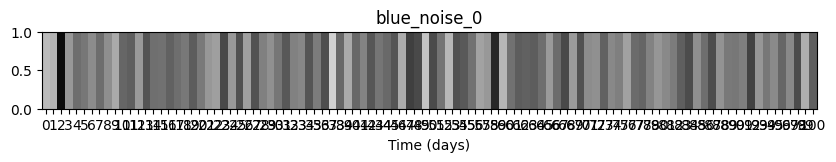

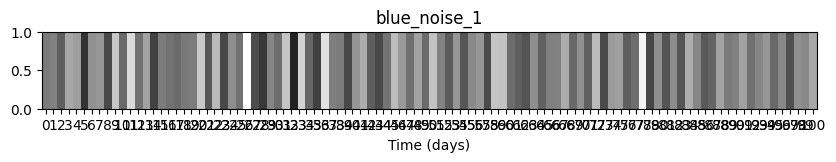

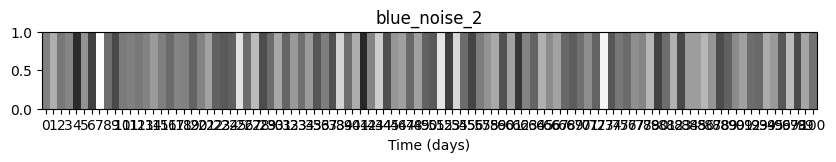

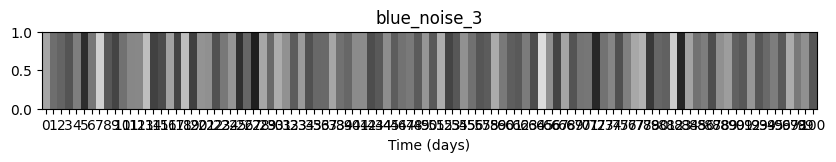

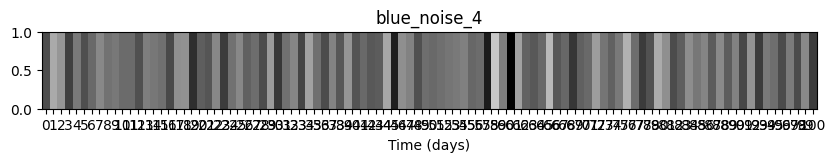

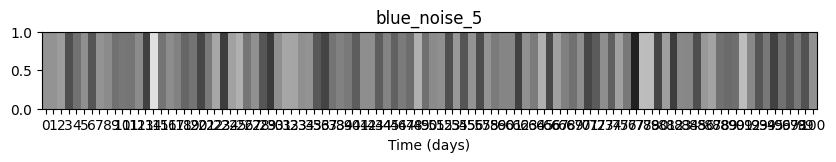

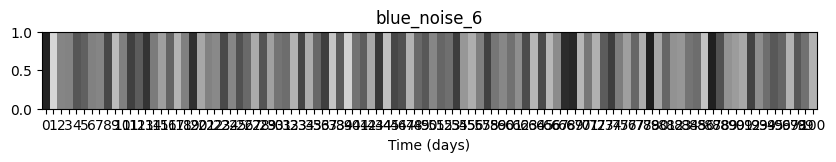

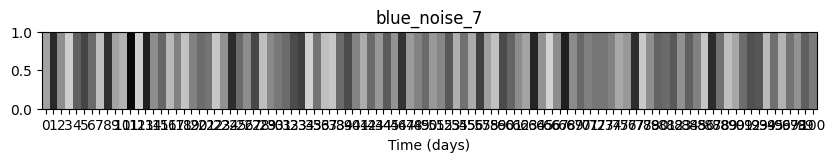

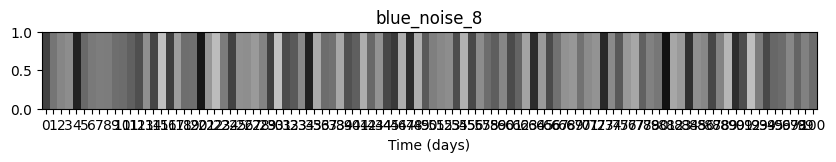

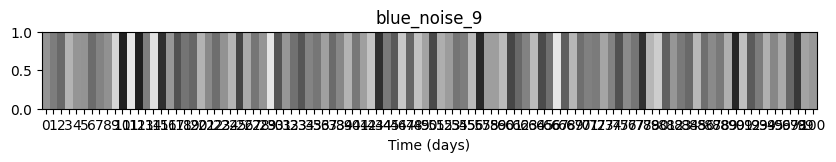

Emax=64
Strains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
..........

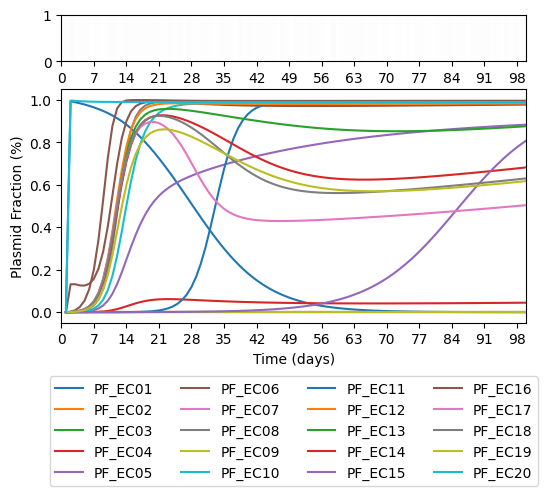

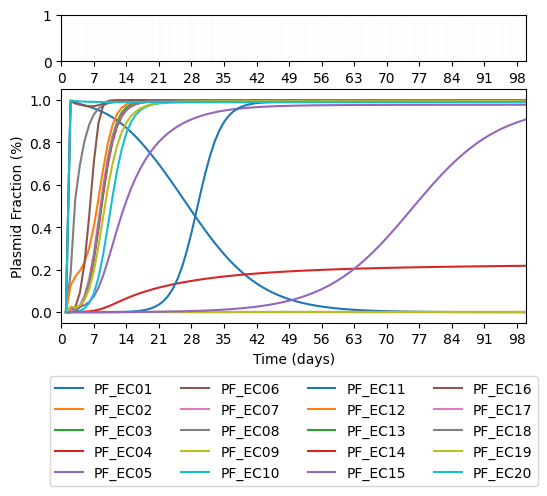

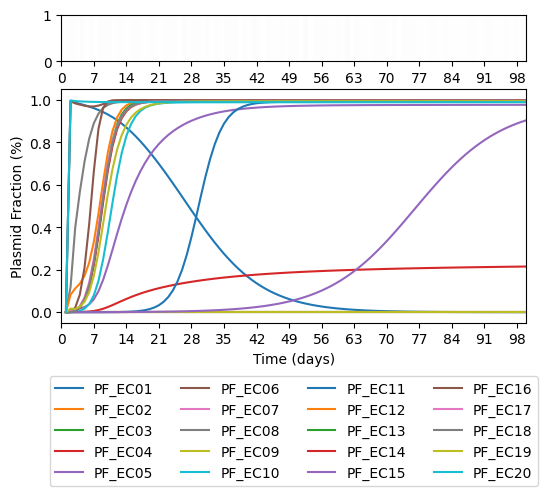

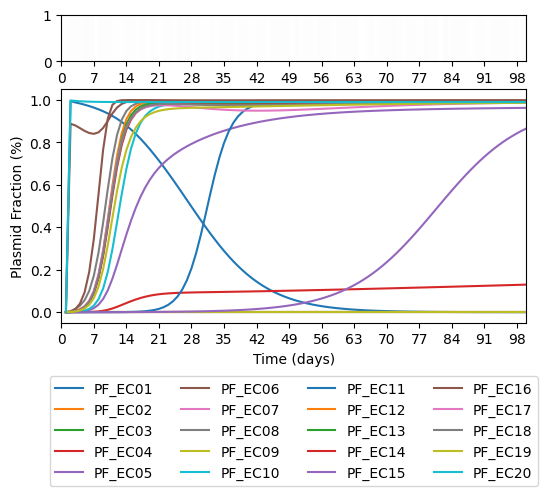

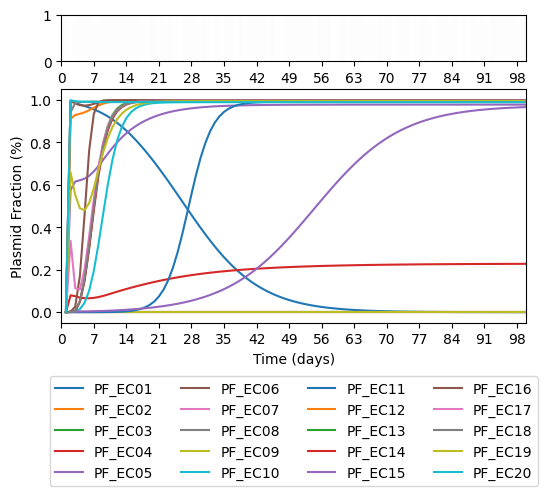

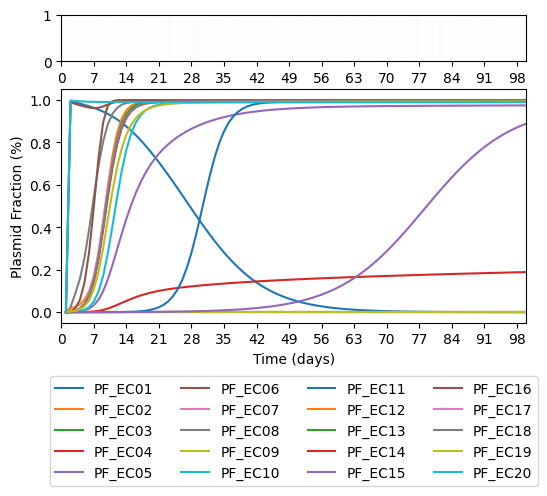

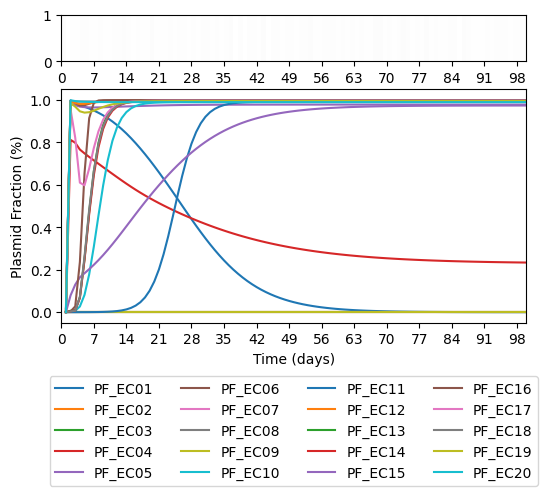

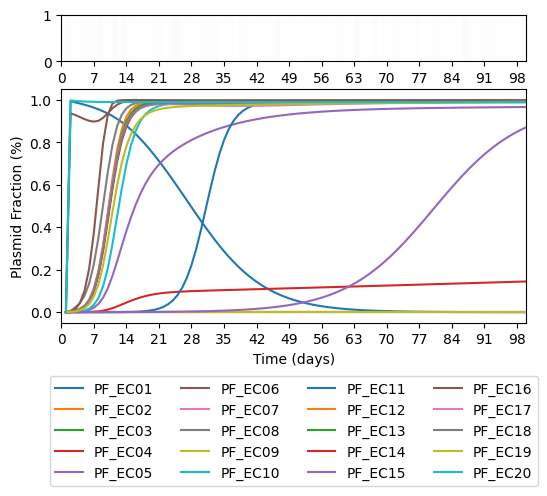

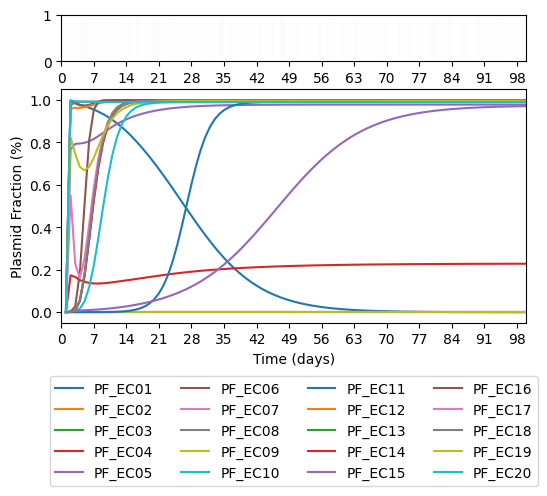

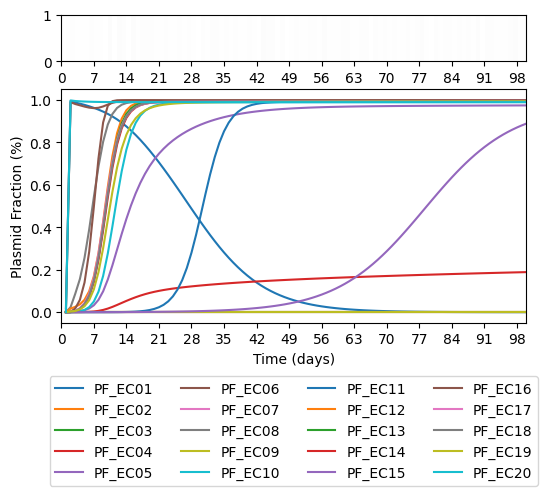

In [45]:
Emax = 2**6
result_data_blue_high = runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Emax, num_Es)

plotPFFinalPoint: env 0


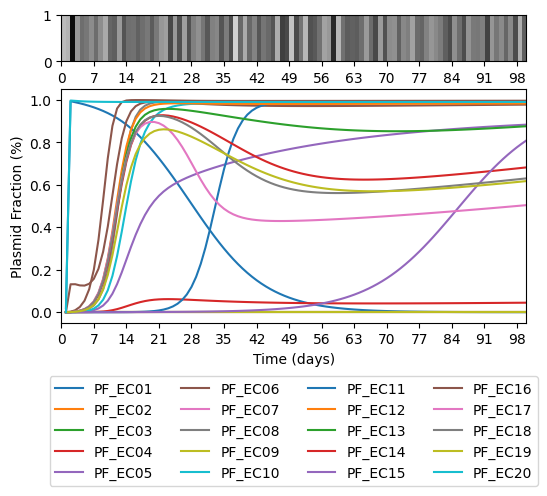

plotPFFinalPoint: env 1


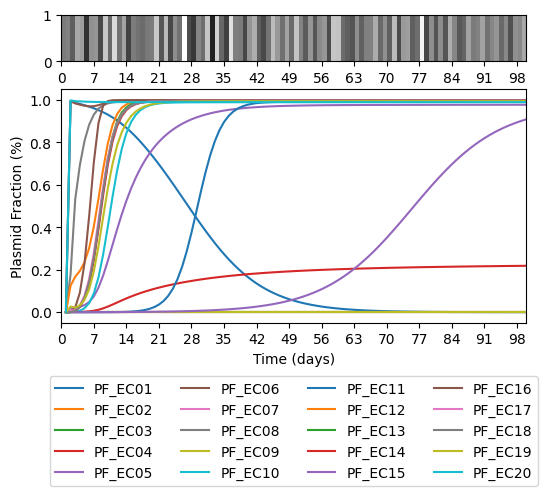

plotPFFinalPoint: env 2


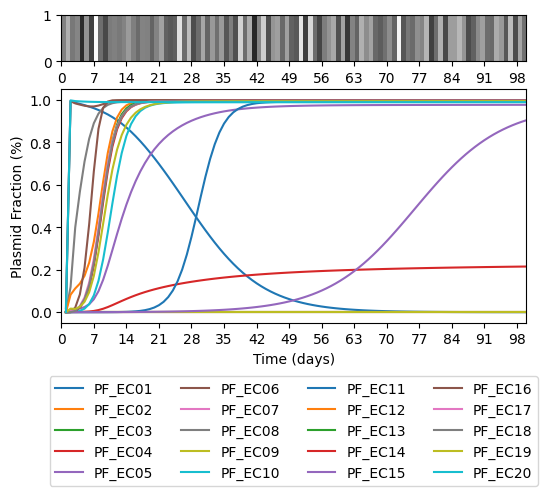

plotPFFinalPoint: env 3


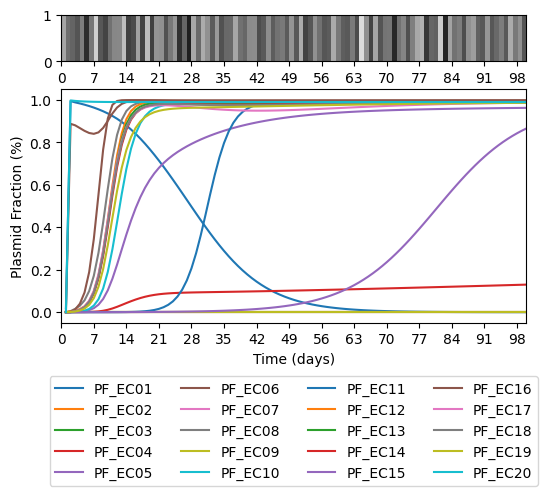

plotPFFinalPoint: env 4


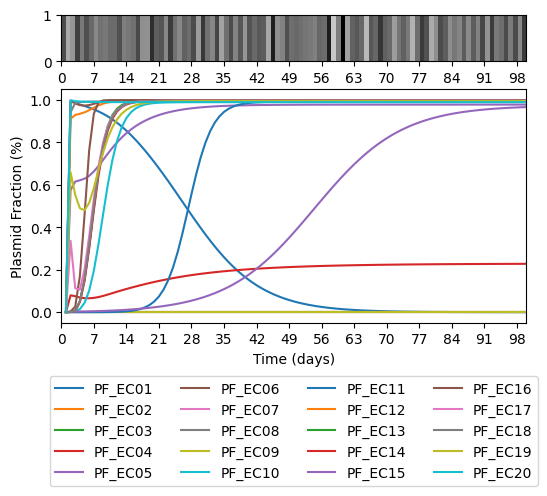

plotPFFinalPoint: env 5


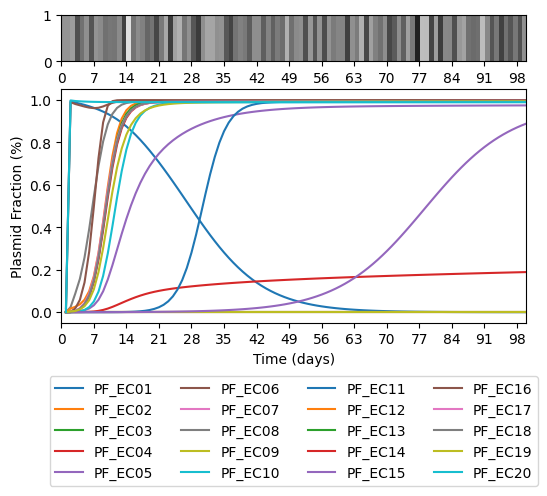

plotPFFinalPoint: env 6


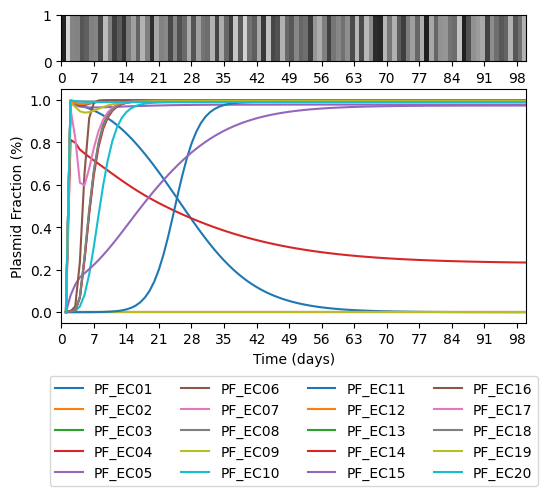

plotPFFinalPoint: env 7


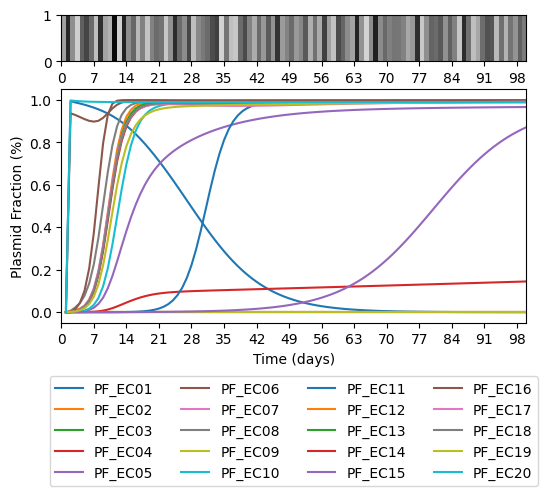

plotPFFinalPoint: env 8


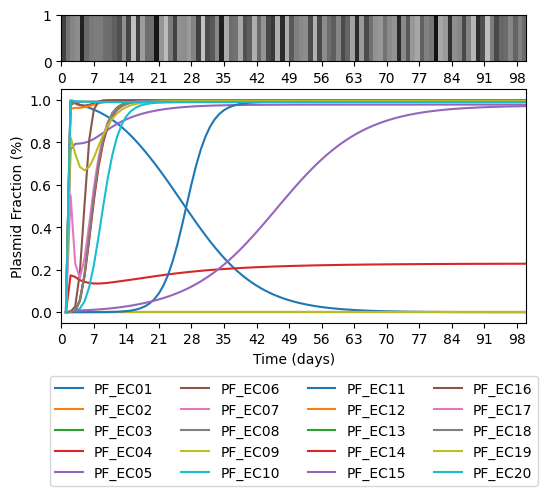

plotPFFinalPoint: env 9


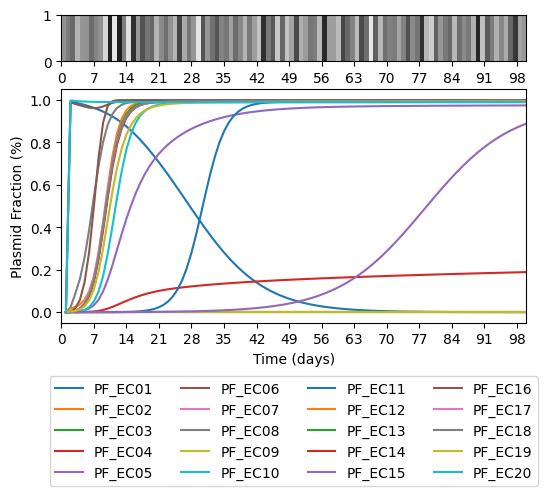

In [46]:

results_data=result_data_blue_high #example
def plotMultistrainExperiment(type_experiment, model_params, results):
    for env_index, env_data in results.items():
        try:
            print(f"plotPFFinalPoint: env {env_index}")
            plotPFFinalPoint(model_params, strains_subset, env_data['ts'], env_data['ys'], env_data['params'],  strain_names, E=env_data['E'], Emax=Emax, str_E="%s_%s"%(str_E,env_index), save_path='path_to_save')
        except Exception as e:
            print(f"An error occurred while plotting data for environment index {env_index}: {e}")

plotMultistrainExperiment(type_experiment, model_params, results_data)


In [47]:
def get_final_from_results(results, variable):
    """
    Extract the final (last time point) value of a given variable for each environment.

    Parameters
    ----------
    results : dict
        Results dictionary indexed by environment.
    variable : str
        Key to extract from each environment entry (e.g., "Bp", "Bf", "Btots", "freqps").

    Returns
    -------
    dict
        Mapping: env_index -> final value (env_data[variable][-1]).
    """
    final_values = {}
    for env_index, env_data in results.items():
        final_values[env_index] = env_data[variable][-1]
    return final_values


def add_dictionaries(dict1, dict2):
    """
    Add two dictionaries element-wise (requires identical keys).

    Returns
    -------
    dict
        Mapping: key -> dict1[key] + dict2[key].
    """
    if dict1.keys() != dict2.keys():
        missing_1 = dict2.keys() - dict1.keys()
        missing_2 = dict1.keys() - dict2.keys()
        raise KeyError(f"Mismatched keys. Missing in dict1: {missing_1}; missing in dict2: {missing_2}")

    return {k: dict1[k] + dict2[k] for k in dict1}


def divide_dictionaries(numerator_dict, denominator_dict):
    """
    Divide two dictionaries element-wise (requires identical keys).

    Notes
    -----
    Division by zero returns None for that key.

    Returns
    -------
    dict
        Mapping: key -> numerator_dict[key] / denominator_dict[key] (or None if denominator is 0).
    """
    if numerator_dict.keys() != denominator_dict.keys():
        missing_1 = denominator_dict.keys() - numerator_dict.keys()
        missing_2 = numerator_dict.keys() - denominator_dict.keys()
        raise KeyError(f"Mismatched keys. Missing in numerator: {missing_1}; missing in denominator: {missing_2}")

    out = {}
    for k in numerator_dict:
        denom = denominator_dict[k]
        out[k] = None if denom == 0 else numerator_dict[k] / denom
    return out


# Final values per environment
final_Bp = get_final_from_results(results_data, "Bp")
print("Final 'Bp' per environment:", final_Bp)

final_Bf = get_final_from_results(results_data, "Bf")
print("Final 'Bf' per environment:", final_Bf)

final_Btots = get_final_from_results(results_data, "Btots")
print("Final 'Btots' per environment:", final_Btots)

# Consistency check: Btots = Bp + Bf
final_Btots2 = add_dictionaries(final_Bf, final_Bp)
print("* Confirmation 'Btots' per environment:", final_Btots2)

final_freqps = get_final_from_results(results_data, "freqps")
print("Final 'freqps' per environment:", final_freqps)

# Consistency check: freqps = Bp / Btots
final_freqps2 = divide_dictionaries(final_Bp, final_Btots)
print("* Confirmation 'freqps' per environment:", final_freqps2)


Final 'Bp' per environment: {0: np.float64(206285468.14456826), 1: np.float64(984843133.2252076), 2: np.float64(972952782.3957244), 3: np.float64(615230154.3162423), 4: np.float64(1014962279.6783305), 5: np.float64(874352731.9333886), 6: np.float64(1017020306.2892934), 7: np.float64(683813196.070649), 8: np.float64(1015918005.1743509), 9: np.float64(873658690.243875)}
Final 'Bf' per environment: {0: np.float64(756472274.584136), 1: np.float64(40474015.56189636), 2: np.float64(51701180.36170405), 3: np.float64(384401431.6808705), 4: np.float64(11964964.77482067), 5: np.float64(144296171.5785264), 6: np.float64(10013325.236500764), 7: np.float64(321233720.19395316), 8: np.float64(11058601.065109827), 9: np.float64(144945088.1880396)}
Final 'Btots' per environment: {0: np.float64(962757742.7287043), 1: np.float64(1025317148.7871039), 2: np.float64(1024653962.7574284), 3: np.float64(999631585.9971126), 4: np.float64(1026927244.4531511), 5: np.float64(1018648903.5119151), 6: np.float64(1027

In [48]:
def get_auc_from_results(results, variable):
    """
    Compute the area under the curve (AUC) of a variable across transfers.

    Notes
    -----
    - Time is taken as the discrete transfer index (0..N-1).
    - Uses the trapezoidal rule.
    """
    auc_values = {}

    for env_index, env_data in results.items():
        values = env_data[variable]
        t = np.arange(len(env_data["Btots"]))
        auc_values[env_index] = np.trapz(values, t)

    return auc_values


# AUC summaries per environment
auc_freqps = get_auc_from_results(results_data, "freqps")
print("AUC of 'freqps' per environment:", auc_freqps)

auc_Bp = get_auc_from_results(results_data, "Bp")
print("AUC of 'Bp' per environment:", auc_Bp)

auc_Bf = get_auc_from_results(results_data, "Bf")
print("AUC of 'Bf' per environment:", auc_Bf)

auc_Btots = get_auc_from_results(results_data, "Btots")
print("AUC of 'Btots' per environment:", auc_Btots)


AUC of 'freqps' per environment: {0: np.float64(21.629298994263152), 1: np.float64(85.24225489309589), 2: np.float64(83.32929037787935), 3: np.float64(49.56971030589603), 4: np.float64(92.03203468705729), 5: np.float64(71.14170596202962), 6: np.float64(94.20964373472789), 7: np.float64(54.60143853357517), 8: np.float64(92.61490533151056), 9: np.float64(71.06968689881613)}
AUC of 'Bp' per environment: {0: np.float64(21278380449.704918), 1: np.float64(87512256244.77603), 2: np.float64(85466255824.50597), 3: np.float64(49636848570.5923), 4: np.float64(94413909454.66064), 5: np.float64(72401538162.05829), 6: np.float64(95944086998.2725), 7: np.float64(54888047656.73793), 8: np.float64(94891177659.01521), 9: np.float64(72324587198.22244)}
AUC of 'Bf' per environment: {0: np.float64(74457615409.49524), 1: np.float64(12696514774.761045), 2: np.float64(14683105528.394484), 3: np.float64(48280762208.458786), 4: np.float64(5363717274.414355), 5: np.float64(27072083350.217827), 6: np.float64(3391

/tmp/ipython-input-2774808428.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_values[env_index] = np.trapz(values, t)


In [49]:
def get_mean_from_results(results, variable):
    """
    Compute the time-averaged mean of a variable for each environment.
    """
    mean_values = {}

    for env_index, env_data in results.items():
        mean_values[env_index] = np.mean(env_data[variable])

    return mean_values


# Mean values per environment
mean_freqps = get_mean_from_results(results_data, "freqps")
print("Mean of 'freqps' per environment:", mean_freqps)

mean_Bp = get_mean_from_results(results_data, "Bp")
print("Mean of 'Bp' per environment:", mean_Bp)

mean_Bf = get_mean_from_results(results_data, "Bf")
print("Mean of 'Bf' per environment:", mean_Bf)

mean_Btots = get_mean_from_results(results_data, "Btots")
print("Mean of 'Btots' per environment:", mean_Btots)


Mean of 'freqps' per environment: {0: np.float64(0.2174286037004358), 1: np.float64(0.8577849678900935), 2: np.float64(0.8385240443846267), 3: np.float64(0.49892138875884096), 4: np.float64(0.9268741371509158), 5: np.float64(0.7159797985807004), 6: np.float64(0.9499294995640691), 7: np.float64(0.5495834841778716), 8: np.float64(0.9329887445921117), 9: np.float64(0.7152557085504081)}
Mean of 'Bp' per environment: {0: np.float64(213815937.48761445), 1: np.float64(880047456.0777726), 2: np.float64(859528002.5598778), 3: np.float64(499445333.54302645), 4: np.float64(949214561.9667511), 5: np.float64(728387834.4283783), 6: np.float64(964526608.1109456), 7: np.float64(552300238.0516043), 8: np.float64(953992018.1810265), 9: np.float64(727614854.6175903)}
Mean of 'Bf' per environment: {0: np.float64(748412691.8961862), 1: np.float64(127172895.35849981), 2: np.float64(147095918.07419688), 3: np.float64(484752641.69336677), 4: np.float64(53698376.294589214), 5: np.float64(271454339.5911787), 6:

In [50]:
def get_final_density_from_results(results):
    """
    Extract final densities of all strains at the end of the last day for each environment.

    Notes
    -----
    - Assumes `ys` stores one entry per day.
    - State vector format: [S, A, B_TC(1..n), B_WT(1..n)].
    - Returns TC and WT densities in the order they appear in the state vector.
    """
    final_densities = {}

    for env_index, env_data in results.items():
        ys = env_data["ys"]
        last_day = len(ys) - 1

        num_strains = int((len(ys[0]) - 2) / 2)
        densities = []

        print(f"Env {env_index}")
        for idx in range(2, 2 + 2 * num_strains):
            val = ys[last_day][idx][-1]
            print(f"  Strain {idx} = {val}")
            densities.append(val)

        final_densities[env_index] = densities

    return final_densities


final_densities = get_final_density_from_results(results_data)
print("Final densities of all strains:", final_densities)


Env 0
  Strain 2 = 1.3218675520271113e-25
  Strain 3 = 0.0
  Strain 4 = 0.0
  Strain 5 = 35292654.051107004
  Strain 6 = 6.88798309331083e-18
  Strain 7 = 1.5259788694715663e-06
  Strain 8 = 0.0
  Strain 9 = 3.910715100404389e-06
  Strain 10 = 0.0
  Strain 11 = 170992813.58781797
  Strain 12 = 2.8565926018410985e-31
  Strain 13 = 2.6930221990651128e-09
  Strain 14 = 5.879466806639431e-09
  Strain 15 = 1.0305035351510227e-06
  Strain 16 = 9.287188918380887e-37
  Strain 17 = 7.728571812822007e-08
  Strain 18 = 1.3853699966314374e-10
  Strain 19 = 0.505636730673632
  Strain 20 = 1.8205248695297908e-30
  Strain 21 = 7.299504673467833e-27
  Strain 22 = 1.0434918605335674e-21
  Strain 23 = 1.4084091940222196e-16
  Strain 24 = 1.8192961005999075e-26
  Strain 25 = 753930993.2736084
  Strain 26 = 9.116318578220387e-19
  Strain 27 = 3.5247942147886944e-08
  Strain 28 = 7.35115227564662e-08
  Strain 29 = 2.8020825816934284e-08
  Strain 30 = 66747.53461262527
  Strain 31 = 2474533.4790706257
  Str

In [51]:
def get_final_diversity_from_results(results):
    """
    Compute Shannon diversity from final-day densities for each environment.

    Notes
    -----
    - Uses the last time point of the last day in `env_data["ys"]`.
    - Extracts only the WT block (indices: 2 + n .. 2 + 2n - 1), as in the original code.
    - Returns a dict: env_index -> shannon_index (or None if total density is 0).
    """
    diversity_by_env = {}

    for env_index, env_data in results.items():
        ys = env_data["ys"]
        last_day = len(ys) - 1
        num_strains = int((len(ys[0]) - 2) / 2)

        final_densities = []
        for strain_index in range(2 + num_strains, 2 + 2 * num_strains):
            final_densities.append(ys[last_day][strain_index][-1])

        print(f"Environment {env_index}: Densities = {final_densities}")

        diversity_by_env[env_index] = calculate_shannon_index(final_densities)

    return diversity_by_env


def calculate_shannon_index(densities):
    """
    Compute Shannon index from a list/array of nonnegative abundances.

    Returns
    -------
    float or None
        Shannon index, or None if total abundance is 0.
    """
    x = np.asarray(densities, dtype=float)
    x = np.clip(x, a_min=0.0, a_max=None)

    total = x.sum()
    if total == 0:
        return None

    p = x / total
    p = p[p > 0]
    return -np.sum(p * np.log(p))


final_diversity = get_final_diversity_from_results(results_data)
print("Final Shannon index of all plasmid-bearing strains:", final_diversity)


Environment 0: Densities = [np.float64(1.0434918605335674e-21), np.float64(1.4084091940222196e-16), np.float64(1.8192961005999075e-26), np.float64(753930993.2736084), np.float64(9.116318578220387e-19), np.float64(3.5247942147886944e-08), np.float64(7.35115227564662e-08), np.float64(2.8020825816934284e-08), np.float64(66747.53461262527), np.float64(2474533.4790706257), np.float64(2.2837904500400386e-33), np.float64(4.778111212339852e-11), np.float64(8.349569952555768e-10), np.float64(4.81012977922149e-07), np.float64(2.20175514108315e-37), np.float64(3.2636348176284947e-10), np.float64(1.3631171056475644e-10), np.float64(0.2968436315916937), np.float64(1.1286451437931553e-30), np.float64(7.485778278840544e-29)]
Environment 1: Densities = [np.float64(2.1232935788246088e-20), np.float64(2.3129695827278232e-26), np.float64(4.740515915441083e-28), np.float64(31060670.964176707), np.float64(7.571462902582956e-21), np.float64(2.792149402042553e-09), np.float64(1.7061566151519922e-17), np.floa